In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [88]:
df = pd.read_csv('PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [89]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

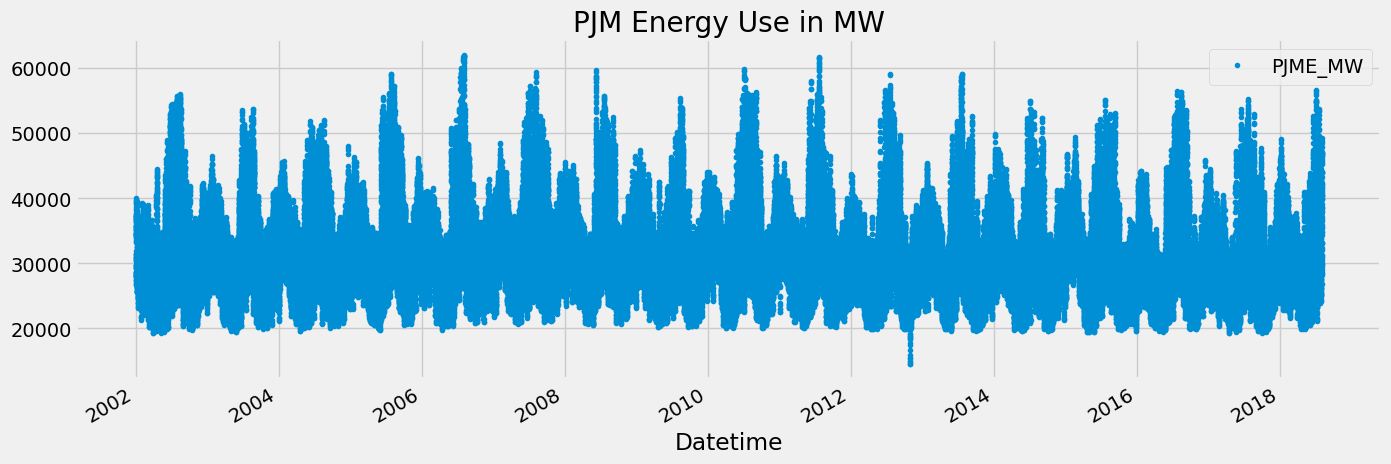

In [90]:
color_palette = sns.color_palette()
df.plot(style='.',
        figsize = (15,5),
        color = color_palette[0],
        title='PJM Energy Use in MW')
plt.show()

## Generate more feature

In [91]:
def create_features(df:pd.DataFrame):
    '''
        Create more features from the original dataset base on time series index
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear
    return df

df  = create_features(df)

In [92]:
df.columns,display(df.sample(10))

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2006-02-07 08:00:00,37575.0,8,1,1,2,2006,38,7,6
2008-06-19 06:00:00,24939.0,6,3,2,6,2008,171,19,25
2002-04-10 07:00:00,26931.0,7,2,2,4,2002,100,10,15
2009-11-18 07:00:00,30666.0,7,2,4,11,2009,322,18,47
2012-07-19 07:00:00,35476.0,7,3,3,7,2012,201,19,29
2008-05-25 22:00:00,27965.0,22,6,2,5,2008,146,25,21
2005-12-01 02:00:00,26135.0,2,3,4,12,2005,335,1,48
2016-11-30 23:00:00,27385.0,23,2,4,11,2016,335,30,48
2016-10-09 12:00:00,25365.0,12,6,4,10,2016,283,9,40


(Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
        'dayofmonth', 'weekofyear'],
       dtype='object'),
 None)

## Viz feature

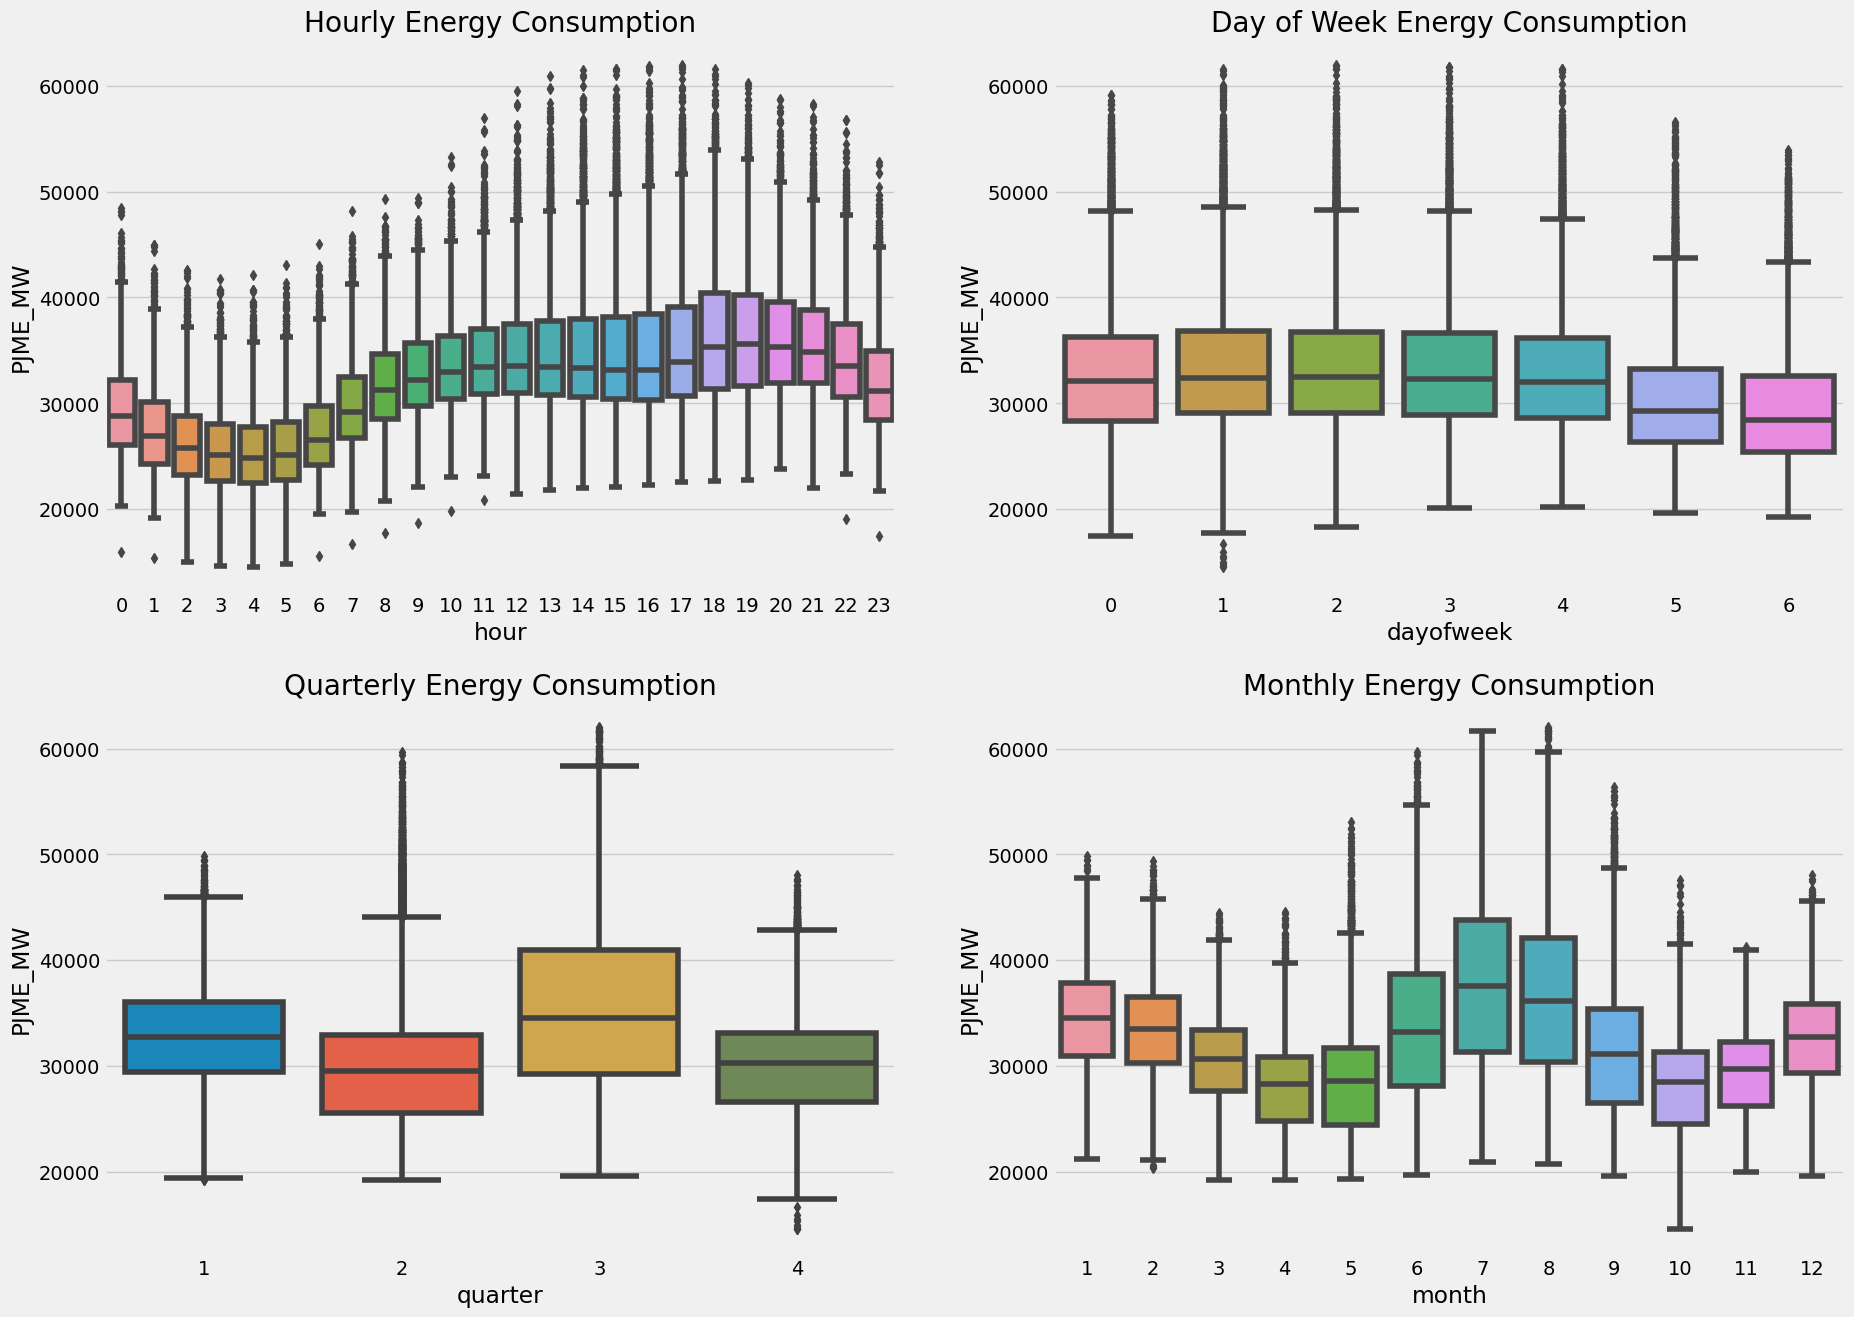

In [93]:
fig,ax = plt.subplots(2,2,figsize=(20,15))
sns.boxplot(x='hour',y='PJME_MW',data=df,ax=ax[0,0])
sns.boxplot(x='dayofweek',y='PJME_MW',data=df,ax=ax[0,1])
sns.boxplot(x='quarter',y='PJME_MW',data=df,ax=ax[1,0])
sns.boxplot(x='month',y='PJME_MW',data=df,ax=ax[1,1])

# set title 
ax[0,0].set_title('Hourly Energy Consumption')
ax[0,1].set_title('Day of Week Energy Consumption')
ax[1,0].set_title('Quarterly Energy Consumption')
ax[1,1].set_title('Monthly Energy Consumption')
plt.show()

## Train test split

**We will get datetime before 2014 as training data and the rest as test data.**

In [94]:
train = df.loc[df.index < '1-1-2015']
test = df.loc[df.index >= '1-1-2015']
train.shape,test.shape

((113926, 9), (31440, 9))

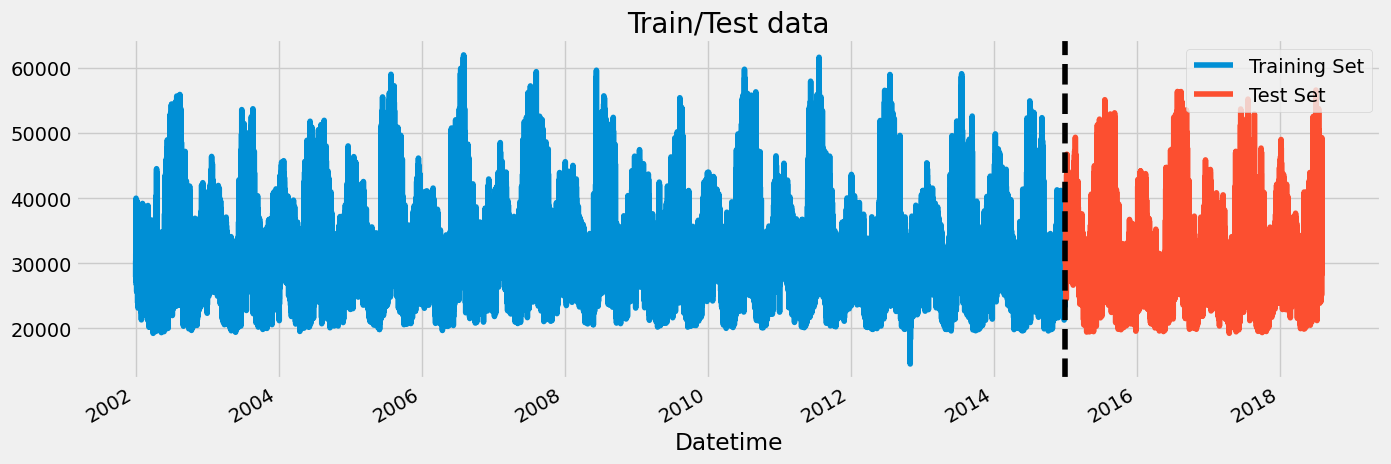

In [95]:
# Plot train and test data
fig, ax = plt.subplots(1,1,figsize=(15,5))
train['PJME_MW'].plot(ax=ax,label='Training set',title='Train/Test data')
test['PJME_MW'].plot(ax=ax,label='Test set')
plt.legend(['Training Set', 'Test Set'])
ax.axvline('1-1-2015',color = 'black', linestyle='--')
plt.show()

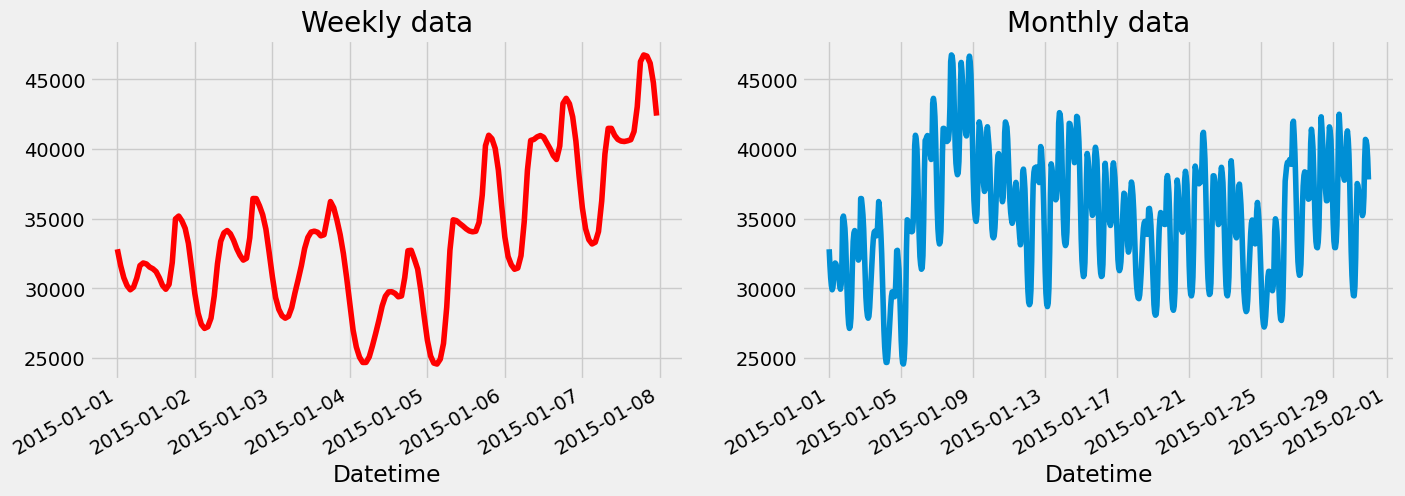

In [96]:
# Viz data in weekly and monthly
fig,ax = plt.subplots(1,2,figsize=(15,5))
condition1 = (df.index >= '1-1-2015') & (df.index < '1-8-2015')
condition2 = (df.index >= '1-1-2015') & (df.index < '1-31-2015')
df['PJME_MW'].loc[condition1].plot(ax = ax[0],title='Weekly data',color = 'red')
df['PJME_MW'].loc[condition2].plot(ax = ax[1],title='Monthly data')
plt.show()

## Create model

In [97]:
target = 'PJME_MW'

X_train = train.drop(target,axis=1)
y_train = train[target]

X_test = test.drop(target,axis=1)
y_test = test[target]

In [98]:
model = xgb.XGBRegressor(n_estimators=1000,
                         learning_rate=0.01,
                         eval_metric='rmse',
                         objective='reg:linear',
                         early_stopping_rounds=50,
                         base_score=0.5, 
                         booster='gbtree',
                         max_depth=5)
model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

[16:09:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32602.32020	validation_1-rmse:31654.46401
[100]	validation_0-rmse:12386.25005	validation_1-rmse:11517.49189
[200]	validation_0-rmse:5464.21304	validation_1-rmse:5089.93403
[300]	validation_0-rmse:3509.78426	validation_1-rmse:3783.02965
[400]	validation_0-rmse:3026.68635	validation_1-rmse:3671.92507
[434]	validation_0-rmse:2954.47834	validation_1-rmse:3680.64952


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Feature importance

<AxesSubplot: >

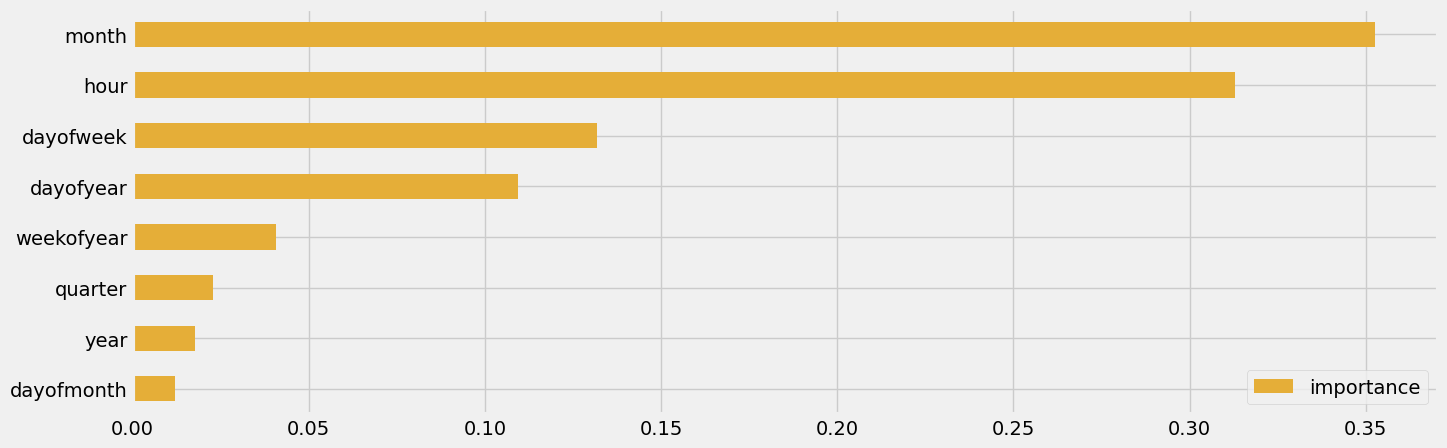

In [99]:
feature_importance_df = pd.DataFrame(data = model.feature_importances_,index=model.feature_names_in_,columns=['importance'])
feature_importance_df.sort_values(by='importance',inplace=True)
feature_importance_df.plot(kind='barh',figsize=(15,5),color = color_palette[2])

## Plot preadiction

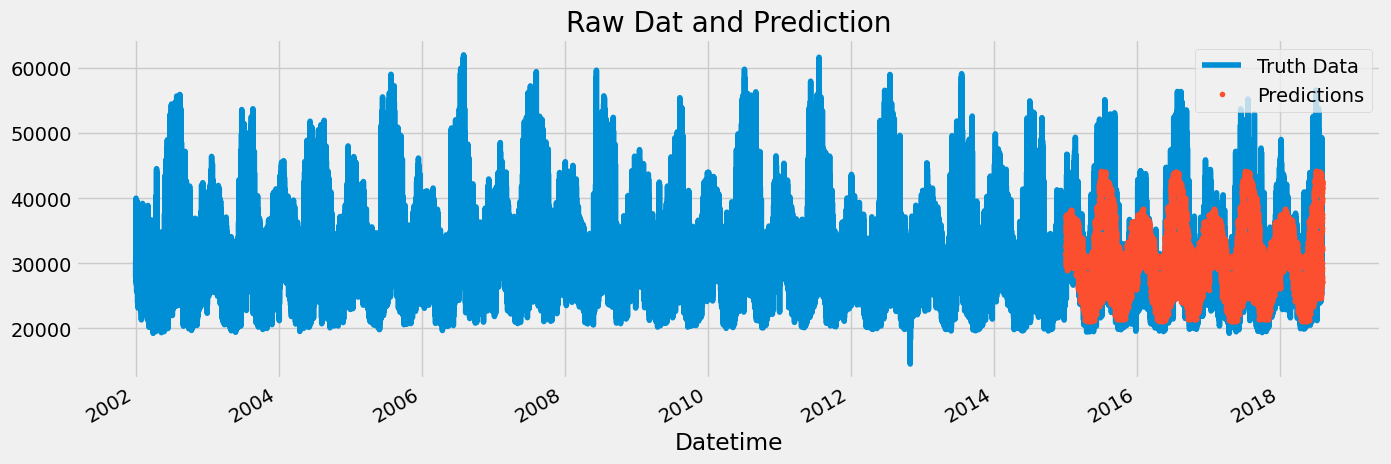

In [100]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
# create ax for the second plot
ax = df['PJME_MW'].plot(figsize=(15, 5))
# plot the predictions
df['prediction'].plot(ax=ax, style='.')
# set the legend
plt.legend(['Truth Data', 'Predictions'])
# set the title
ax.set_title('Raw Dat and Prediction')
plt.show()

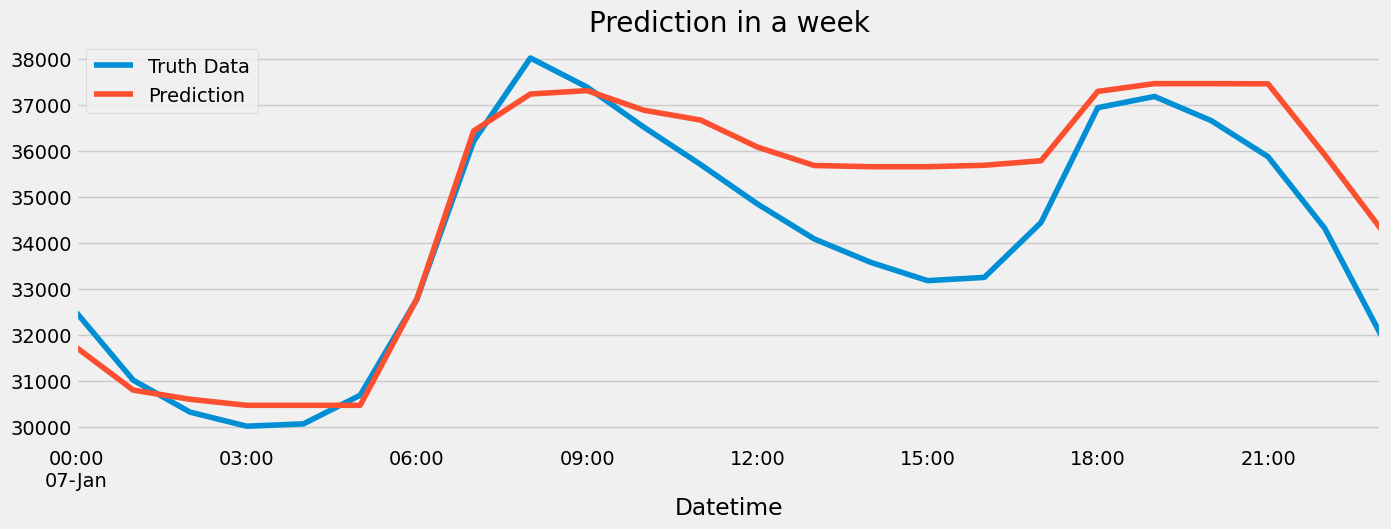

In [113]:
## Prediction in a week
data_week = df.loc[(df.index >= '1-7-2016') & (df.index < '1-8-2016')]
ax = data_week['PJME_MW'].plot(figsize=(15, 5))
data_week['prediction'].plot(ax=ax)
ax.set_title('Prediction in a week')
plt.legend(['Truth Data','Prediction'])
plt.show()

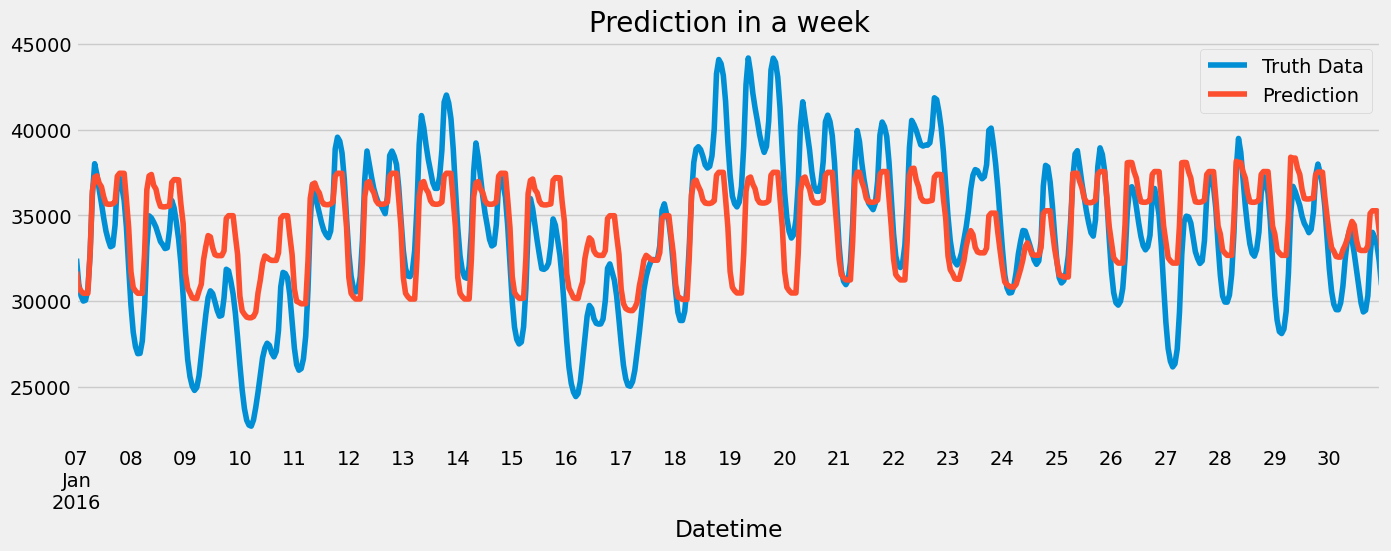

In [112]:
## Prediction in a month
data_week = df.loc[(df.index >= '1-7-2016') & (df.index < '1-31-2016')]
ax = data_week['PJME_MW'].plot(figsize=(15, 5))
data_week['prediction'].plot(ax=ax)
ax.set_title('Prediction in a week')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Get score

In [114]:
score = mean_squared_error(y_test,test['prediction'],squared=False)
print(f'RMSE: {score}')

RMSE: 3667.730844411868


## Caculate error

In [118]:
test['error'] = np.abs(test[target] - test['prediction'])
test['date'] = test.index.date
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,error,date
Datetime,,,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1,31383.787109,1418.212891,2015-01-01
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53,28455.707031,4150.707031,2015-12-31
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53,27371.830078,4215.830078,2015-12-31
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53,27092.269531,4578.269531,2015-12-31
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53,27092.269531,4762.269531,2015-12-31


In [119]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2017-05-02    437.802653
2016-04-04    468.280192
2016-09-27    472.343994
2015-10-28    526.296549
2018-03-28    536.632650
2018-05-17    537.920329
2016-12-30    552.220296
2016-05-01    555.519531
2015-12-19    563.921305
2015-03-10    564.265706
Name: error, dtype: float64

In [120]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13692.446045
2016-08-14    13422.546468
2016-09-10    12217.886312
2016-09-09    11322.431641
2015-02-20    11267.064128
2018-01-06    11010.342936
2016-08-12    10533.171224
2015-02-16    10169.449137
2018-01-07    10105.489990
2017-05-19     9938.362386
Name: error, dtype: float64